In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from utils.depth_camera import DepthCamera
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/estimated_imu+depth",
    experiment="exp_8",
    trial="trial_2",
    subject="subject-1",
    sequence="02",
    groundtruth_dir="data/trajectories/groundtruth",
    voxel_size=0.03
)

In [3]:
pose_file = os.path.join(config.get_groundtruth_dir(), f"{config.get_file_name()}.pose.npz")
motion_dir = config.get_motion_dir(include_secondary=False)

In [4]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000

win_len = int(frame_rate * 4) # 4 seconds window

gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

print(f"Frame rate: {frame_rate:.2f} Hz")
print(f"Window length: {win_len} frames")

Frame rate: 400.91 Hz
Window length: 1603 frames


In [5]:
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=10)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=10)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=10)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=10)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=10)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=10)

In [6]:
# # calculate displacement and rotation
# rotation_matrix = np.identity(4)
# velocity = [0, 0, 0]

# for i in tqdm.tqdm(range(1, len(imu_df))):
#     v = imu_df.iloc[i].values
#     da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
#     acceleration = imu_df.iloc[i, [1, 2, 3]].values
#     gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
#     acceleration = acceleration - gravity_rotated[:3]
    
#     imu_df.iloc[i, 1] = acceleration[0]
#     imu_df.iloc[i, 2] = acceleration[1]
#     imu_df.iloc[i, 3] = acceleration[2]
    
#     # rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

# accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
# accel_mavg.fillna(0, inplace=True)

# imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

In [7]:
# imu_df = imu_df.iloc[win_len:]

In [8]:
# # calculate displacement and rotation
# rotation_matrix = np.identity(4)

# velocity = [0, 0, 0]

# for i in tqdm.tqdm(range(1, len(imu_df))):
#     v = imu_df.iloc[i].values
    
#     dt = v[7]
    
#     # current displacement and rotation
#     da = np.degrees([v[j + 4] * dt for j in range(3)])
    
#     acceleration = imu_df.iloc[i, [1, 2, 3]].values

#     d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
#     d = np.dot(rotation_matrix, np.array([*d, 1]))
    
#     imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
#     imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
#     imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
#     velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
#     rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

In [9]:
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")

depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]
local_t = poses["local_t"]

start_ind = 30 * 5
sequence_ts = sequence_ts[start_ind:]

In [10]:
# local_pcds = []

# for t in tqdm.trange(len(sequence_ts)):
#     depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
#     pcd = depth_camera.depth_to_point_cloud(depth_img_file)
#     pcd = pcd.voxel_down_sample(voxel_size=0.03)
#     local_pcds.append(pcd)

In [11]:
gt_xyz = trajectory_t[start_ind:, :3, 3]
gt_trajectory = helpers.make_pcd(gt_xyz)

In [12]:
# open3d.visualization.draw_geometries([gt_trajectory])

First second is used to find the gravity vector

In [13]:
def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0,0]**2 + R[1,0]**2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1], R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [14]:
elapsed_time = (sequence_ts - sequence_ts[0]) // 1e3
calibration_ts = np.argwhere(elapsed_time == 0).flatten()

In [61]:
# velocity
velocities = np.diff(gt_xyz[calibration_ts], axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)
linear_acceleration = np.diff(velocities, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts][1:]).reshape(-1, 1)

In [110]:
calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]]) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]])].copy()

In [111]:
rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

resampled_angular_velocity = []
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

resampled_angular_velocity = np.array(resampled_angular_velocity).T

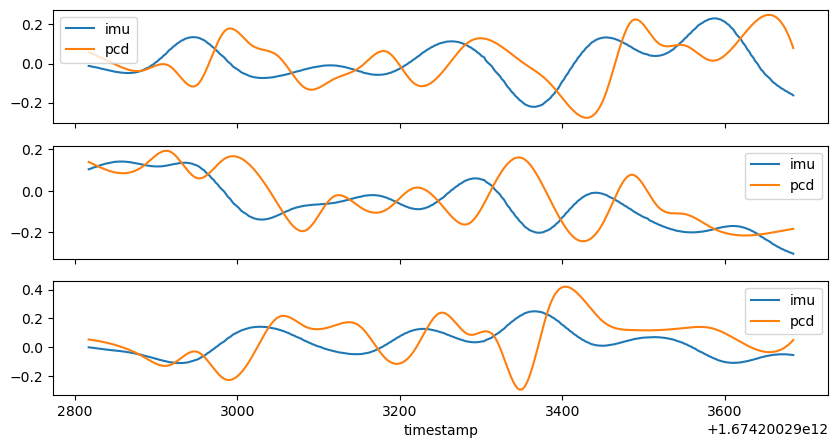

In [112]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

In [113]:
corr = np.correlate(calibration_imu_df.xg.values, resampled_angular_velocity[:, 0], mode='full')

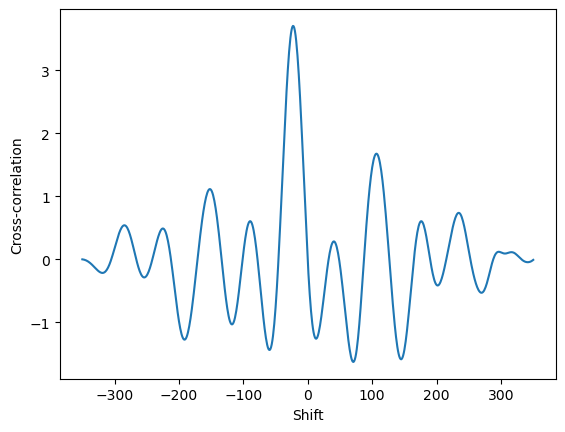

In [114]:
shifts = np.arange(-calibration_imu_df.shape[0] + 1, calibration_imu_df.shape[0])  # All possible shifts

plt.plot(shifts, corr)
plt.xlabel('Shift')
plt.ylabel('Cross-correlation')
plt.show()

In [115]:
delta = (np.argmax(corr) - calibration_imu_df.shape[0] + 1) * 1000 / frame_rate

print(f"Time shift: {delta} ms")

Time shift: -57.36949744357152 ms


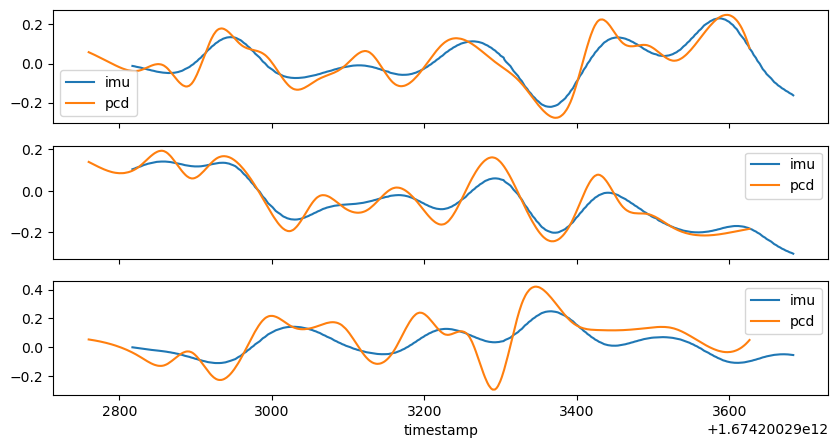

In [116]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

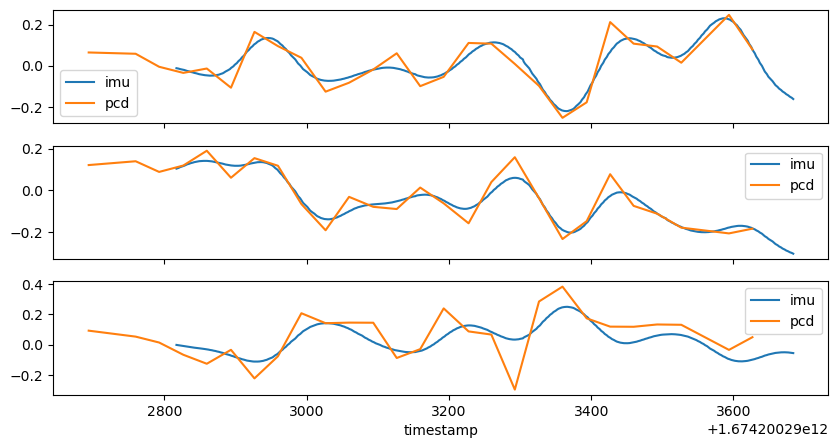

In [117]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 2], label="pcd")
axs[2].legend()

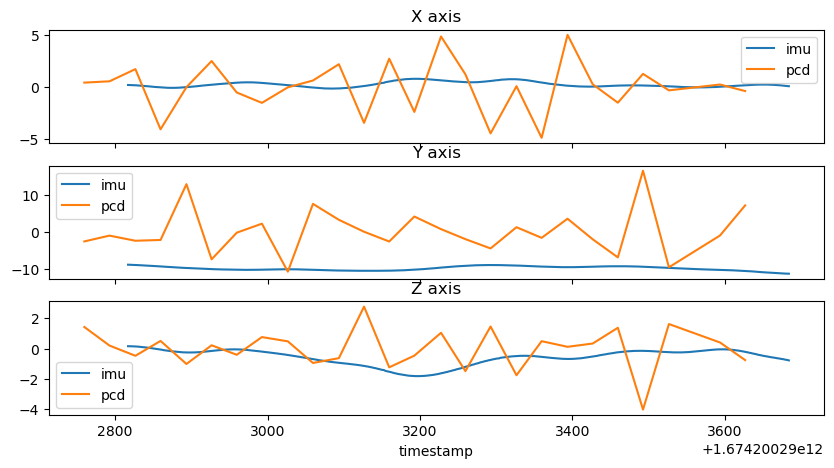

In [118]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xa", ax=axs[0], label="imu")
axs[0].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 0], label="pcd")
axs[0].set_title("X axis")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="ya", ax=axs[1], label="imu")
axs[1].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 1], label="pcd")
axs[1].set_title("Y axis")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="za", ax=axs[2], label="imu")
axs[2].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 2], label="pcd")
axs[2].set_title("Z axis")
axs[2].legend()

In [119]:
calibration_imu_df = calibration_imu_df[calibration_imu_df.timestamp < sequence_ts[calibration_ts][-1] + delta].copy()

In [120]:
linear_acceleration_interp = []
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

linear_acceleration_interp = np.array(linear_acceleration_interp).T

velocity_interp = []
velocity_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, velocities[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
velocity_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, velocities[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
velocity_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, velocities[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

velocity_interp = np.array(velocity_interp).T


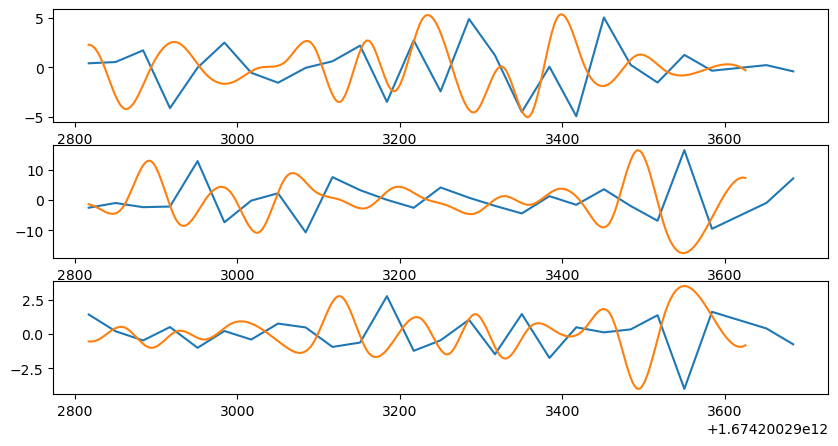

In [121]:
# plot linear acceleration and interpolated linear acceleration in subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 5))

axs[0].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 0], label="Acceleration")
axs[0].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 0], label="Interpolated & Adjusted")

axs[1].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 1], label="Acceleration")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 1], label="Interpolated & Adjusted")

axs[2].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 2], label="Acceleration")
axs[2].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 2], label="Interpolated & Adjusted")

In [122]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]
# velocity = velocity_interp[-1]

for i in tqdm.tqdm(range(1, len(calibration_imu_df))):
    v = calibration_imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = calibration_imu_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    calibration_imu_df.iloc[i, 8] = calibration_imu_df.iloc[i - 1, 8] + d[0]
    calibration_imu_df.iloc[i, 9] = calibration_imu_df.iloc[i - 1, 9] + d[1]
    calibration_imu_df.iloc[i, 10] = calibration_imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 326/326 [00:00<00:00, 2764.84it/s]


In [123]:
imu_xyz = calibration_imu_df.loc[:, ["x", "y", "z"]].values
imu_velocity = np.diff(imu_xyz, axis=0) * 1e3 / np.diff(calibration_imu_df.timestamp.values).reshape(-1, 1)
imu_acceleration = np.diff(imu_velocity, axis=0) * 1e3 / np.diff(calibration_imu_df.timestamp.values[1:]).reshape(-1, 1)

imu_acceleration[:, 0] = gaussian_filter1d(imu_acceleration[:, 0], 10)
imu_acceleration[:, 1] = gaussian_filter1d(imu_acceleration[:, 1], 10)
imu_acceleration[:, 2] = gaussian_filter1d(imu_acceleration[:, 2], 10)

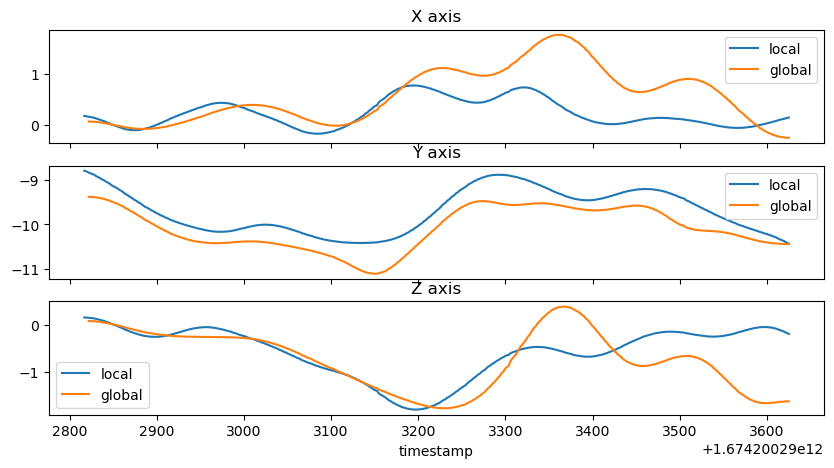

In [124]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xa", ax=axs[0], label="local")
axs[0].plot(calibration_imu_df.timestamp.values[2:], imu_acceleration[:, 0], label="global")
axs[0].set_title("X axis")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="ya", ax=axs[1], label="local")
axs[1].plot(calibration_imu_df.timestamp.values[2:], imu_acceleration[:, 1], label="global")
axs[1].set_title("Y axis")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="za", ax=axs[2], label="local")
axs[2].plot(calibration_imu_df.timestamp.values[2:], imu_acceleration[:, 2], label="global")
axs[2].set_title("Z axis")
axs[2].legend()

In [125]:
calibration_imu_df.iloc[2:, 1:4] = imu_acceleration

In [126]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(calibration_imu_df))):
    v = calibration_imu_df.iloc[i].values
    
    dt = v[7]
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = calibration_imu_df.iloc[i, [1, 2, 3]].values
    acceleration = np.dot(helpers.inv_transform(rotation_matrix), np.array([*acceleration, 1]))
    # acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3]
    
    calibration_imu_df.iloc[i, 1] = acceleration[0]
    calibration_imu_df.iloc[i, 2] = acceleration[1]
    calibration_imu_df.iloc[i, 3] = acceleration[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 326/326 [00:00<00:00, 3482.50it/s]


In [127]:
gravity = calibration_imu_df.loc[:, ["xa", "ya", "za"]].values - linear_acceleration_interp

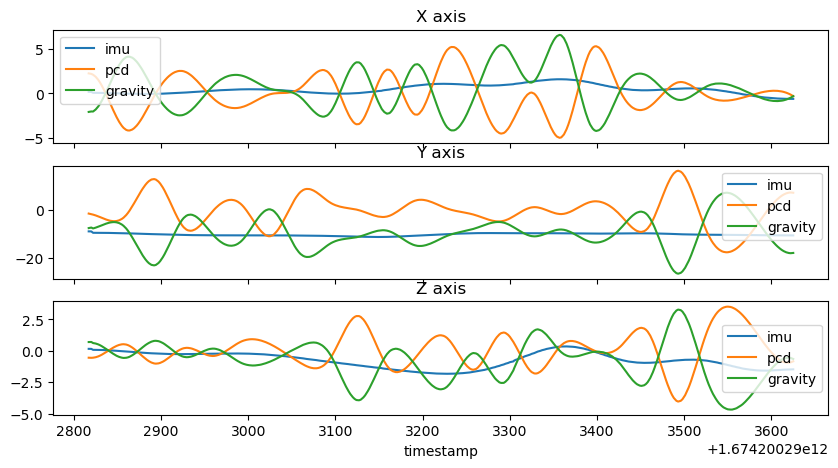

In [128]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xa", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 0], label="pcd")
axs[0].plot(calibration_imu_df.timestamp.values, gravity[:, 0], label="gravity")
axs[0].set_title("X axis")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="ya", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 1], label="pcd")
axs[1].plot(calibration_imu_df.timestamp.values, gravity[:, 1], label="gravity")
axs[1].set_title("Y axis")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="za", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[:, 2], label="pcd")
axs[2].plot(calibration_imu_df.timestamp.values, gravity[:, 2], label="gravity")
axs[2].set_title("Z axis")
axs[2].legend()

In [129]:
print(f"gravity magnitude: {np.linalg.norm(gravity, axis=1).mean()}")

gravity magnitude: 10.777856194520426


In [137]:
gravity = np.mean(gravity, axis=0)

In [188]:
imu_sequence_df = imu_df[imu_df.timestamp > sequence_ts[calibration_ts][-1] + delta].copy()
# imu_sequence_df = imu_df.copy()

In [189]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_sequence_df))):
    v = imu_sequence_df.iloc[i].values
    da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
    acceleration = imu_sequence_df.iloc[i, [1, 2, 3]].values
    # gravity_rotated = np.dot(helpers.inv_transform(rotation_matrix), np.array([*gravity, 1]))
    gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
    acceleration = acceleration - gravity_rotated[:3]
    
    imu_sequence_df.iloc[i, 1] = acceleration[0]
    imu_sequence_df.iloc[i, 2] = acceleration[1]
    imu_sequence_df.iloc[i, 3] = acceleration[2]
    
    # rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

accel_mavg = imu_sequence_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
accel_mavg.fillna(0, inplace=True)

imu_sequence_df[["xa", "ya", "za"]] = imu_sequence_df[["xa", "ya", "za"]] - accel_mavg

100%|██████████| 4945/4945 [00:01<00:00, 3849.43it/s]


In [190]:
# calculate displacement and rotation
# rotation_matrix = np.identity(4)
rotation_matrix = trajectory_t[start_ind + calibration_ts[-1]]

# velocity = [0, 0, 0]
velocity = velocity_interp[-1]

for i in tqdm.tqdm(range(1, len(imu_sequence_df))):
    v = imu_sequence_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_sequence_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    imu_sequence_df.iloc[i, 8] = imu_sequence_df.iloc[i - 1, 8] + d[0]
    imu_sequence_df.iloc[i, 9] = imu_sequence_df.iloc[i - 1, 9] + d[1]
    imu_sequence_df.iloc[i, 10] = imu_sequence_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 4945/4945 [00:02<00:00, 2118.52it/s]


In [191]:
estimated_xyz = imu_sequence_df[["x", "y", "z"]].values
estimated_trajectory = helpers.make_pcd(estimated_xyz)
estimated_trajectory.paint_uniform_color([1, 0, 0])

PointCloud with 4946 points.

In [192]:
gt_xyz = trajectory_t[calibration_ts[-1] + start_ind:, :3, 3]
# gt_xyz = trajectory_t[:, :3, 3]
gt_trajectory = helpers.make_pcd(gt_xyz)
gt_trajectory.paint_uniform_color([0, 1, 0])

PointCloud with 313 points.

In [193]:
open3d.visualization.draw_geometries([estimated_trajectory, gt_trajectory])